<a href="https://colab.research.google.com/github/kumarrajesh1992-arch/kumarrajesh1992-arch.github.io/blob/main/Chart4_State_HDI_Regression_HDI_Residuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I uploaded CC10_State_Level_Regression.csv to Colab and imported libraries.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [ ]:
import sys, sklearn
print("python:", sys.version)
print("sklearn:", sklearn.__version__)

python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
sklearn: 1.6.1


I read the state-level dataset into a pandas DataFrame.

In [ ]:
df_raw = pd.read_csv("CC10_State_Level_Regression.csv")
df_raw.head()

,State,SHDI,LGNIC
0,Andaman and Nicobar Islands,0.706,9.334
1,Andhra Pradesh,0.642,9.027
2,Arunachal Pradesh,0.683,9.064
3,Assam,0.615,8.387
4,Bihar,0.577,8.253


In [ ]:
print("Rows, Cols:", df_raw.shape)
print(df_raw.columns.tolist())
df_raw.info()

Rows, Cols: (36, 3)
['State', 'SHDI', 'LGNIC']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   36 non-null     object 
 1   SHDI    36 non-null     float64
 2   LGNIC   36 non-null     float64
dtypes: float64(2), object(1)
memory usage: 996.0+ bytes


I identified the columns for State, HDI, and log GNI per capita.

In [ ]:
cols = [c.lower().strip() for c in df_raw.columns]

def find_col(candidates):
    for cand in candidates:
        for original in df_raw.columns:
            if original.lower().strip() == cand:
                return original
    for cand in candidates:
        for original in df_raw.columns:
            if cand in original.lower().strip():
                return original
    return None

state_col = find_col(["state", "state_name", "statename"])
hdi_col   = find_col(["hdi", "shdi"])
gni_col   = find_col(["lgnic", "log_gni_pc", "log_gni_per_capita", "log_gni", "gni_log"])

print("Detected columns:")
print("State:", state_col)
print("HDI:", hdi_col)
print("log GNI pc:", gni_col)

Detected columns:
State: State
HDI: SHDI
log GNI pc: LGNIC


I cleaned HDI and log GNI per capita as numeric and removed missing values.

In [ ]:
df = df_raw[[state_col, hdi_col, gni_col]].copy()
df.columns = ["State", "HDI", "log_GNI_pc"]

# coerce to numeric (handles strings, commas, blanks)
df["HDI"] = pd.to_numeric(df["HDI"], errors="coerce")
df["log_GNI_pc"] = pd.to_numeric(df["log_GNI_pc"], errors="coerce")

# drop missing
df = df.dropna(subset=["State", "HDI", "log_GNI_pc"]).reset_index(drop=True)

df.head()

,State,HDI,log_GNI_pc
0,Andaman and Nicobar Islands,0.706,9.334
1,Andhra Pradesh,0.642,9.027
2,Arunachal Pradesh,0.683,9.064
3,Assam,0.615,8.387
4,Bihar,0.577,8.253


I transformed inputs into standardised X matrix and standardised y vector.

In [ ]:
X = df[["log_GNI_pc"]].values
y = df["HDI"].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_std = scaler_X.fit_transform(X)
y_std = scaler_y.fit_transform(y)

print("X_std shape:", X_std.shape)
print("y_std shape:", y_std.shape)

X_std shape: (36, 1)
y_std shape: (36, 1)


I ran an OLS-style linear regression of HDI on log GNI per capita (standardised).

In [ ]:
model = LinearRegression()
model.fit(X_std, y_std)

print("Coefficient (standardised):", float(model.coef_[0][0]))
print("Intercept (standardised):", float(model.intercept_[0]))
print("R^2 (standardised):", model.score(X_std, y_std))

Coefficient (standardised): 0.923834752473628
Intercept (standardised): 2.2262480821004145e-15
R^2 (standardised): 0.8534706498780105


In [ ]:

yhat_std = model.predict(X_std)
print("Predictions:", yhat_std.shape, "| Any NaN:", np.isnan(yhat_std).any())

Predictions: (36, 1) | Any NaN: False


I computed de-trended HDI = residuals (actual HDI minus predicted HDI), in original HDI units.

In [ ]:

yhat = scaler_y.inverse_transform(yhat_std)

df["HDI_pred"] = yhat.flatten()
df["residual_HDI"] = df["HDI"] - df["HDI_pred"]

df.sort_values("residual_HDI", ascending=False).head(10)

,State,HDI,log_GNI_pc,HDI_pred,residual_HDI
20,Manipur,0.683,8.671,0.632424,0.050576
16,Kerala,0.758,9.400,0.717777,0.040223
23,Nagaland,0.679,8.888,0.657831,0.021169
29,Sikkim,0.712,9.183,0.692370,0.019630
13,Jammu and Kashmir,0.720,9.270,0.702556,0.017444
26,Puducherry,0.741,9.456,0.724333,0.016667
3,Assam,0.615,8.387,0.599173,0.015827
9,Goa,0.760,9.643,0.746227,0.013773
21,Meghalaya,0.650,8.737,0.640151,0.009849
30,Tamil Nadu,0.692,9.102,0.682886,0.009114


In [ ]:
print(df[["HDI","HDI_pred","residual_HDI"]].describe())
print("Residual mean (should be ~0):", df["residual_HDI"].mean())

             HDI   HDI_pred  residual_HDI
count  36.000000  36.000000  3.600000e+01
mean    0.673861   0.673861  3.083953e-18
std     0.048606   0.044904  1.860589e-02
min     0.577000   0.583484 -3.571535e-02
25%     0.632500   0.633917 -1.161322e-02
50%     0.680000   0.682301  1.089128e-03
75%     0.709750   0.710664  9.297547e-03
max     0.760000   0.746227  5.057608e-02
Residual mean (should be ~0): 3.0839528461809902e-18


I visualised which states over-perform or under-perform on HDI after accounting for income.

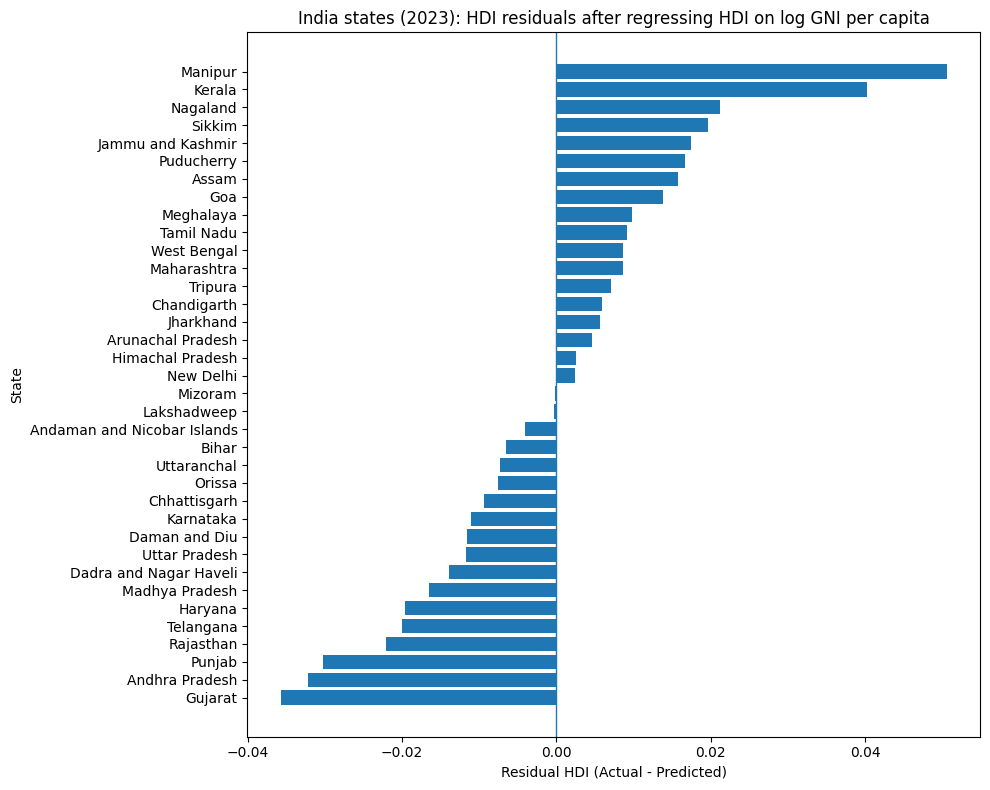

In [ ]:
df_plot = df.sort_values("residual_HDI", ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_plot["State"], df_plot["residual_HDI"])
plt.axvline(0, linewidth=1)
plt.title("India states (2023): HDI residuals after regressing HDI on log GNI per capita")
plt.xlabel("Residual HDI (Actual - Predicted)")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [ ]:
print("Top 5 outperformers (highest residual):")
print(df.sort_values("residual_HDI", ascending=False)[["State","HDI","log_GNI_pc","residual_HDI"]].head(5))

print("\nTop 5 underperformers (lowest residual):")
print(df.sort_values("residual_HDI", ascending=True)[["State","HDI","log_GNI_pc","residual_HDI"]].head(5))

Top 5 outperformers (highest residual):
                State    HDI  log_GNI_pc  residual_HDI
20            Manipur  0.683       8.671      0.050576
16             Kerala  0.758       9.400      0.040223
23           Nagaland  0.679       8.888      0.021169
29             Sikkim  0.712       9.183      0.019630
13  Jammu and Kashmir  0.720       9.270      0.017444

Top 5 underperformers (lowest residual):
             State    HDI  log_GNI_pc  residual_HDI
10         Gujarat  0.646       9.092     -0.035715
1   Andhra Pradesh  0.642       9.027     -0.032105
27          Punjab  0.698       9.489     -0.030197
28       Rajasthan  0.652       9.027     -0.022105
31       Telangana  0.660       9.077     -0.019959


I plotted the underlying regression relationship (HDI vs log GNI per capita).

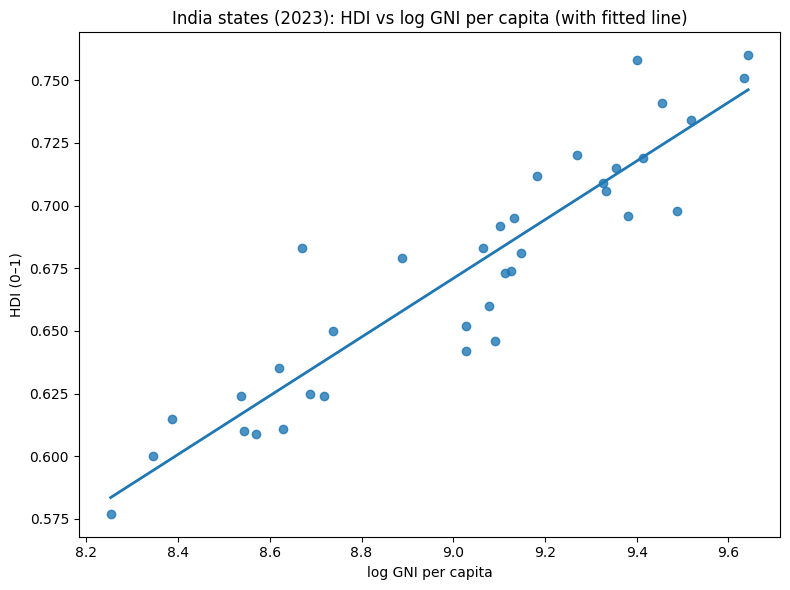

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df["log_GNI_pc"], df["HDI"], alpha=0.8)


tmp = df.sort_values("log_GNI_pc")
plt.plot(tmp["log_GNI_pc"], tmp["HDI_pred"], linewidth=2)

plt.title("India states (2023): HDI vs log GNI per capita (with fitted line)")
plt.xlabel("log GNI per capita")
plt.ylabel("HDI (0–1)")
plt.tight_layout()
plt.show()

 I saved the residual table for use in Vega-Lite / report writing.

In [ ]:
df_out = df.sort_values("residual_HDI", ascending=False)
df_out.to_csv("CC10_state_residuals_2023.csv", index=False)
print("Saved: CC10_state_residuals_2023.csv")
df_out.head()

Saved: CC10_state_residuals_2023.csv


,State,HDI,log_GNI_pc,HDI_pred,residual_HDI
20,Manipur,0.683,8.671,0.632424,0.050576
16,Kerala,0.758,9.400,0.717777,0.040223
23,Nagaland,0.679,8.888,0.657831,0.021169
29,Sikkim,0.712,9.183,0.692370,0.019630
13,Jammu and Kashmir,0.720,9.270,0.702556,0.017444
